In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from datetime import datetime as DT

In [2]:
sync_df = pd.read_feather("out/async_test/sync-v2.feather")
async_df = pd.read_feather("out/async_test/async.feather")
async_df.head()

,train/acc,train/loss,train/epoch,train/batch_idx,train/time,training_start,training_end,node/idx,node/kind,parent/idx,parent/kind,round,train/rel_time,strategy,mode,workers
0,0.03125,2.358010,0,0,2024-03-30 17:17:09.127373,2024-03-30 17:17:09.074136,2024-03-30 17:17:09.873179,5,worker,0,leader,0,2.980267,FedAsync,async,32
1,0.06250,2.351708,0,1,2024-03-30 17:17:09.165965,2024-03-30 17:17:09.074136,2024-03-30 17:17:09.873179,5,worker,0,leader,0,3.018859,FedAsync,async,32
2,0.03125,2.329051,0,2,2024-03-30 17:17:09.204116,2024-03-30 17:17:09.074136,2024-03-30 17:17:09.873179,5,worker,0,leader,0,3.057010,FedAsync,async,32
3,0.00000,2.345125,0,3,2024-03-30 17:17:09.242295,2024-03-30 17:17:09.074136,2024-03-30 17:17:09.873179,5,worker,0,leader,0,3.095189,FedAsync,async,32
4,0.25000,2.283327,0,4,2024-03-30 17:17:09.251636,2024-03-30 17:17:09.074136,2024-03-30 17:17:09.873179,5,worker,0,leader,0,3.104530,FedAsync,async,32


In [95]:
def get_workers_rounds(df: pd.DataFrame) -> tuple[list, list]:
    df_workers = async_df.query("`node/kind` == 'worker'")["node/idx"].unique()
    df_workers = list(df_workers)
    df_workers = sorted(df_workers)

    df_rounds = async_df["round"].unique()
    df_rounds = list(df_rounds)
    df_rounds = sorted(df_rounds)

    return df_workers, df_rounds


def plot_execution_schedule(
        df: pd.DataFrame,
        relative_time: bool = True,
        rel_time_format: str = "%H:%M:%S",
        ax=None
):
    if ax is None:
        _, ax = plt.subplots()

    workers, rounds = get_workers_rounds(df)
    colors = ("tab:red", "tab:green", "tab:blue", "tab:orange", "tab:pink")
    for w in workers:
        x_bars = []
        for r in rounds:
            tmp = df.query(f"`node/idx` == {w} and round == {r}")
            tup = tmp.iloc[0]

            start = tup["training_start"].to_pydatetime()
            end = tup["training_end"].to_pydatetime()

            delta = (end - start)
            x_bars.append((start, delta))

        height = (w - 0.5, 1)
        ax.broken_barh(x_bars, height, facecolors=colors)

    if relative_time:
        ground_start = df.training_start.min()
        ground_start = ground_start.strftime(rel_time_format)
        ground_start = DT.strptime(str(ground_start), rel_time_format)

        ticks = ax.get_xticks()
        tick_labels = ax.get_xticklabels()
        tick_labels = [lab.get_text() for lab in tick_labels]
        tick_label_dts = [DT.strptime(lab, rel_time_format) for lab in tick_labels]

        new_tick_labels = [
            int((dt - ground_start).total_seconds())
            for dt in tick_label_dts
        ]
        ax.set_xticks(ticks, new_tick_labels)

    return ax

1900-01-01 17:17:08
[datetime.datetime(1900, 1, 1, 17, 17, 10), datetime.datetime(1900, 1, 1, 17, 17, 15), datetime.datetime(1900, 1, 1, 17, 17, 20), datetime.datetime(1900, 1, 1, 17, 17, 25), datetime.datetime(1900, 1, 1, 17, 17, 30), datetime.datetime(1900, 1, 1, 17, 17, 35), datetime.datetime(1900, 1, 1, 17, 17, 40), datetime.datetime(1900, 1, 1, 17, 17, 45), datetime.datetime(1900, 1, 1, 17, 17, 50), datetime.datetime(1900, 1, 1, 17, 17, 55)]


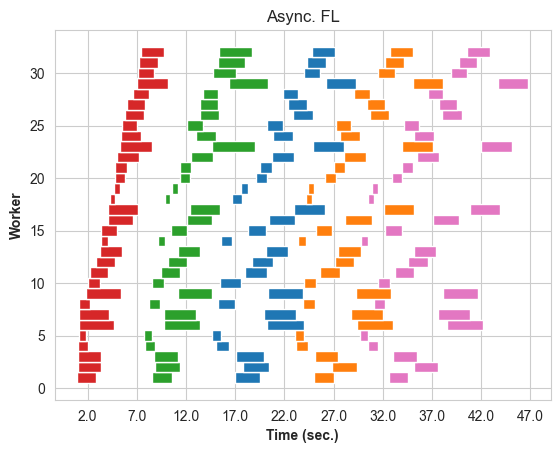

In [74]:
plot_execution_schedule(async_df, relative_time=True)
plt.xlabel("Time (sec.)", weight="bold")
plt.ylabel("Worker", weight="bold")
plt.title("Async. FL")
plt.savefig("async_demo.pdf")
plt.show()

1900-01-01 17:16:09
[datetime.datetime(1900, 1, 1, 17, 16, 10), datetime.datetime(1900, 1, 1, 17, 16, 20), datetime.datetime(1900, 1, 1, 17, 16, 30), datetime.datetime(1900, 1, 1, 17, 16, 40), datetime.datetime(1900, 1, 1, 17, 16, 50), datetime.datetime(1900, 1, 1, 17, 17)]


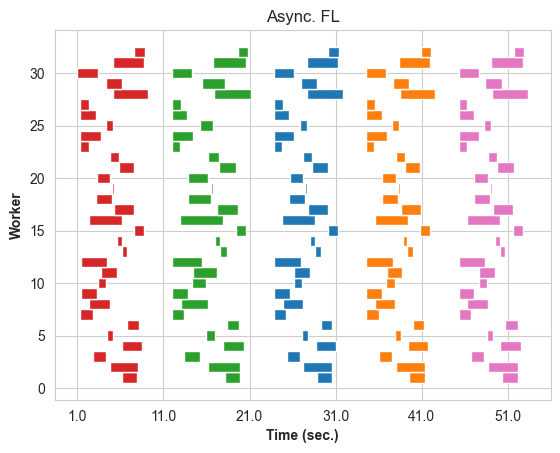

In [73]:
plot_execution_schedule(sync_df, relative_time=True)
plt.xlabel("Time (sec.)", weight="bold")
plt.ylabel("Worker", weight="bold")
plt.title("Async. FL")
plt.savefig("sync_demo.pdf")
plt.show()

In [56]:
sync_df.training_start.describe()

count                          8175
mean     2024-03-30 17:16:35.116855
min      2024-03-30 17:16:09.991850
25%      2024-03-30 17:16:21.931760
50%      2024-03-30 17:16:35.933603
75%      2024-03-30 17:16:47.447763
max      2024-03-30 17:17:00.672570
Name: training_start, dtype: object

[19812.71956019 19812.71967593 19812.71979167 19812.71990741
 19812.72002315 19812.72013889]


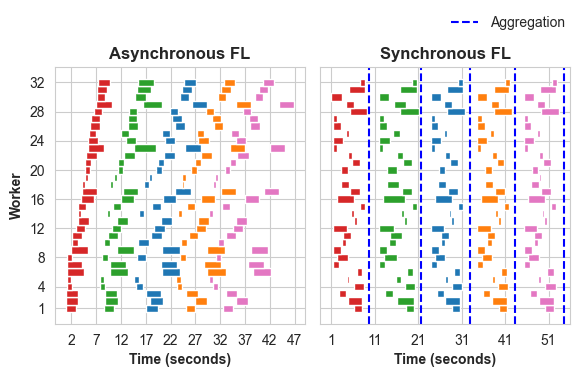

In [154]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 4), sharey=True)
plot_execution_schedule(async_df, relative_time=True, ax=axes[0])
plot_execution_schedule(sync_df, relative_time=True, ax=axes[1])

# axes[0].tick_params(axis="x", labelrotation=45)
# axes[1].tick_params(axis="x", labelrotation=45)

axes[0].set_yticks([1, 4, 8, 12, 16, 20, 24, 28, 32])
axes[1].set_yticks([1, 4, 8, 12, 16, 20, 24, 28, 32])

axes[0].set_ylabel("Worker", weight="bold")
axes[0].set_xlabel("Time", weight="bold")
axes[1].set_xlabel("Time", weight="bold")

axes[0].set_xlabel("Time (seconds)", weight="bold")
axes[1].set_xlabel("Time (seconds)", weight="bold")

axes[0].set_title("Asynchronous FL", weight="bold")
axes[1].set_title("Synchronous FL", weight="bold")

print(axes[1].get_xticks())

for i, vline in enumerate([19812.71966, 19812.7198, 19812.71993, 19812.72005, 19812.72018]):
    if i == 4:
        axes[1].axvline(vline, color="blue", linestyle="--", label="Aggregation")
    else:
        axes[1].axvline(vline, color="blue", linestyle="--")

plt.legend(bbox_to_anchor=(0.75, 1.25), loc="upper center", frameon=False)
plt.tight_layout()
plt.savefig("sync_vs_async.pdf", bbox_inches="tight")
plt.show()